In [73]:
import numpy as np
import pandas as pd

In [74]:
data = pd.read_csv('../data/large_skill_injector_domain.csv')

In [75]:
data.head()

,average,date,highest,lowest,order_count,volume
0,797900000.0,2022-07-01,804300000,793000000.0,182,217
1,797700000.0,2022-07-02,805450000,790000000.0,110,139
2,809600000.0,2022-07-03,818750000,800500000.0,98,110
3,824200000.0,2022-07-04,825000000,819200000.0,103,127
4,829700000.0,2022-07-05,833500000,826500000.0,103,132


In [76]:
# Change the index to the date column since we are doing time series predictions
data = data.set_index('date')


<Axes: xlabel='date'>

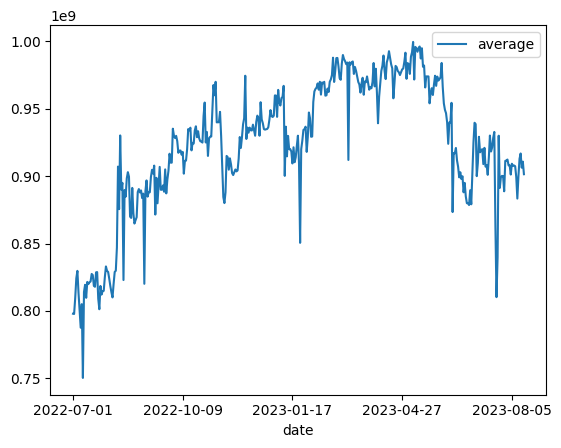

In [77]:
# Plot out each of our values to try and find a stable one to predict decided on average
data.plot.line(y="average", use_index=True)
# data.plot.line(y="lowest", use_index=True)
# data.plot.line(y="highest", use_index=True)

In [78]:
# Create our tomrrow column from our historic data
data["tomorrow"] = data["average"].shift(-1)

In [79]:
# Create our target column for our ML that just determines if the average will increase or decrease
data["target"] = (data["tomorrow"] > data["average"]).astype(int)

In [80]:
# Default model
from sklearn.ensemble import RandomForestClassifier

In [81]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

predictors = ["average", "highest", "lowest", "order_count", "volume"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [82]:
from sklearn.metrics import precision_score

# Get our predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)


In [83]:
# Score our model
precision_score(test["target"], preds)

0.5964912280701754

<Axes: xlabel='date'>

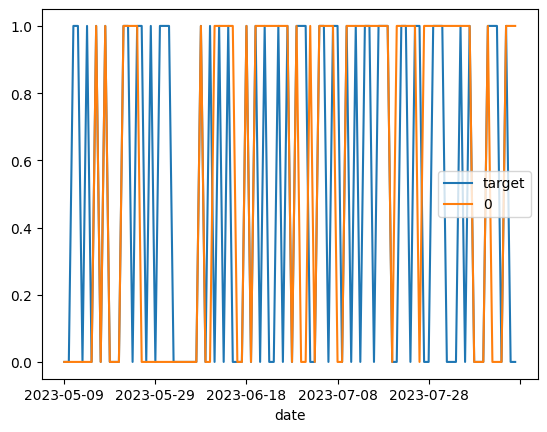

In [84]:
# Plot our predictions
combined = pd.concat([test["target"], preds], axis=1)
combined.plot()

In [85]:
# Start of initial backtest
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined
    

In [86]:
def backtest(data,model, predictors, start=100, step=2):
    all_predictions = []

    for i in range(start, data.shape[0], step):
      train = data.iloc[0:i].copy()
      test = data.iloc[i:(i+step)].copy()
      predictions = predict(train, test, predictors, model)
      all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [87]:
predictions = backtest(data, model, predictors)

In [88]:
predictions["predictions"].value_counts()

predictions
0    159
1    153
Name: count, dtype: int64

In [89]:
precision_score(predictions["target"], predictions["predictions"])

0.6013071895424836

In [90]:
predictions["target"].value_counts() / predictions.shape[0]

target
1    0.525641
0    0.474359
Name: count, dtype: float64

In [91]:
# Adding horizons to the data to help with predictions
horizons = [2,7,14]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()

    ratio_column = f"close_ratio_{horizon}"
    data[ratio_column] = data['average'] / rolling_averages['average']

    trend_column = f"trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["target"]

    new_predictors += [ratio_column, trend_column]

In [92]:
data

,average,highest,lowest,order_count,volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_7,trend_7,close_ratio_14,trend_14
date,,,,,,,,,,,,,
2022-07-01,7.979000e+08,804300000,793000000.0,182,217,7.977000e+08,0,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-02,7.977000e+08,805450000,790000000.0,110,139,8.096000e+08,1,0.999875,NaN,NaN,NaN,NaN,NaN
2022-07-03,8.096000e+08,818750000,800500000.0,98,110,8.242000e+08,1,1.007404,1.0,NaN,NaN,NaN,NaN
2022-07-04,8.242000e+08,825000000,819200000.0,103,127,8.297000e+08,1,1.008936,2.0,NaN,NaN,NaN,NaN
2022-07-05,8.297000e+08,833500000,826500000.0,103,132,8.135000e+08,0,1.003325,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-12,9.129000e+08,914900000,895000000.0,134,208,9.168000e+08,1,1.007116,2.0,1.011356,3.0,1.007919,7.0
2023-08-13,9.168000e+08,918500000,911900000.0,92,134,9.062789e+08,0,1.002131,2.0,1.014184,4.0,1.011787,7.0
2023-08-14,9.062789e+08,919900000,899800000.0,60,71,9.107562e+08,1,0.994229,1.0,1.002802,3.0,1.000599,6.0


In [93]:
# Start of model that predicts the probabilities
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [94]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds< .6] = 0
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined
    

In [95]:
data = data.dropna()
data

,average,highest,lowest,order_count,volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_7,trend_7,close_ratio_14,trend_14
date,,,,,,,,,,,,,
2022-07-15,8.199000e+08,825000000,751700000.0,160,221,8.212000e+08,1,0.999025,1.0,1.017658,4.0,1.015541,7.0
2022-07-16,8.212000e+08,827300000,815000000.0,95,139,8.218000e+08,1,1.000792,1.0,1.016353,4.0,1.015041,8.0
2022-07-17,8.218000e+08,826700000,819900000.0,138,191,8.274000e+08,1,1.000365,2.0,1.004389,5.0,1.014689,8.0
2022-07-18,8.274000e+08,835900000,825000000.0,78,114,8.266000e+08,0,1.003396,2.0,1.008873,5.0,1.021316,8.0
2022-07-19,8.266000e+08,827300000,758500000.0,89,127,8.186000e+08,0,0.999516,1.0,1.006626,4.0,1.020607,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11,9.000000e+08,906150000,887700000.0,158,203,9.129000e+08,1,1.009339,1.0,0.997649,3.0,0.995572,6.0
2023-08-12,9.129000e+08,914900000,895000000.0,134,208,9.168000e+08,1,1.007116,2.0,1.011356,3.0,1.007919,7.0
2023-08-13,9.168000e+08,918500000,911900000.0,92,134,9.062789e+08,0,1.002131,2.0,1.014184,4.0,1.011787,7.0


In [96]:
predictions = backtest(data, model, new_predictors)

In [97]:
predictions["predictions"].value_counts()

predictions
0.0    198
1.0     99
Name: count, dtype: int64

In [98]:
precision_score(predictions["target"], predictions["predictions"])

0.5858585858585859